In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_squared_error as mse
from sklearn.dummy import DummyRegressor
from sklearn import metrics
from sklearn.model_selection import train_test_split
from tqdm import tqdm


# Домашняя работа: деревья решений

В этой домашней работе вам предстоит научиться предсказывать цены товаров из маркетплейса Azamon.

Требования к домашней работе:
- Во всех графиках должны быть подписи через title, legend, etc.
- Во время обучения моделей проверяйте, что у вас не текут данные. Обычно это позитивно влияет на качество модели на тесте, но негативно влияет на оценку 🌚
- Если вы сдаете работу в Google Colaboratory, убедитесь, что ваша тетрадка доступна по ссылке. Если в итоге по каким-то причинам тетрадка не будет открываться у преподавателя, задание не будет засчитано
- Использование мемов допускается, но необходимо соблюдать меру. Несодержательная работа, состоящая только из мемов, получает 0 баллов.

# Загрузка и подготовка данных

In [2]:
!gdown 18PVwZWFbpRbEHW-Hc8R0DUTl9CF1aQa0 -O data.csv

Downloading...
From: https://drive.google.com/uc?id=18PVwZWFbpRbEHW-Hc8R0DUTl9CF1aQa0
To: /Users/ivansmaliakou/tinkoff-ml/hw9-iivansmaliakou/data.csv
100%|██████████████████████████████████████| 30.0M/30.0M [00:03<00:00, 7.61MB/s]


In [4]:
df = pd.read_csv('data.csv').drop(columns=[
    'product_name',
    'index',
    'uniq_id',
    'customers_who_bought_this_item_also_bought',
    'items_customers_buy_after_viewing_this_item',
    'sellers',
    'description', # text
    'product_information', # text
    'product_description', # text
    'customer_questions_and_answers', # text
    'customer_reviews', # text
])

In [53]:
df.columns

Index(['manufacturer', 'price', 'number_available_in_stock',
       'number_of_reviews', 'number_of_answered_questions',
       'average_review_rating', 'amazon_category_and_sub_category'],
      dtype='object')

In [5]:
X, y = df.drop(columns=['price']), df.price

## Очистка данных (1 балл)

Посмотрите на признаки. Есть ли в них пропуски? Какое соотношение между NaN'ами и общим количеством данных? Есть ли смысл выкидывать какие-либо данные из этого датасета?

In [6]:
# NaNs to size of each col ratio
ratios = X.isna().sum() / X.shape[0]
display(ratios)

# NaNs overall ratio
print('nan overall ratio is ', X.isna().sum().sum() / X.size)

missing_ratio_exceeded = {}
missing_ratio_exceeded_data = {}
for _, row in X.iterrows():
    for i in range(3,6):
        if row.isna().sum() / row.size >= i/6:
            if i not in missing_ratio_exceeded_data:
                missing_ratio_exceeded_data[i] = [row]
            else:
                missing_ratio_exceeded_data[i].append(row)
            missing_ratio_exceeded[i] = missing_ratio_exceeded.get(i, 0) + 1
        else:
            break
for (k,v) in missing_ratio_exceeded.items():
    print('more than {k} features out of 6 does not exist in number of rows: {v} or {p:.4f}%'.format(k=k, v=v, p=v / df.shape[0] * 100))

display(pd.DataFrame(missing_ratio_exceeded_data[3]))
pd.DataFrame(missing_ratio_exceeded_data[4])

manufacturer                        0.000585
number_available_in_stock           0.258687
number_of_reviews                   0.001755
number_of_answered_questions        0.078741
average_review_rating               0.001755
amazon_category_and_sub_category    0.064350
dtype: float64

nan overall ratio is  0.06764556764556764
more than 3 features out of 6 does not exist in number of rows: 14 or 0.1638%
more than 4 features out of 6 does not exist in number of rows: 1 or 0.0117%


manufacturer number_available_in_stock number_of_reviews  \
57          POWER CITY TRAINS                     2 new               NaN   
175        The Puppet Company                       NaN                 2   
181           Suma Collection                       NaN                 2   
183                 Me To You                       NaN                 1   
190                 L'Atitude                     4 new               NaN   
2038  Inspiration Bricks Toys                       NaN                 1   
2045               Mega Bloks                       NaN                 1   
3099            Dickie-Tamiya                       NaN               NaN   
3755                     Nici                       NaN                 1   
4438      Steve Jackson Games                       NaN                16   
4626      Steve Jackson Games                       NaN                21   
5548               Chopsticks                     7 new               NaN   
7661                Playmobil                    21 new               NaN   
8074                      NaN                       NaN               202   

      number_of_answered_questions average_review_rating  \
57                             1.0                   NaN   
175                            NaN    4.5 out of 5 stars   
181                            NaN    5.0 out of 5 stars   
183                            NaN    4.0 out of 5 stars   
190                            1.0                   NaN   
2038                           NaN    4.0 out of 5 stars   
2045                           NaN    5.0 out of 5 stars   
3099                           1.0                   NaN   
3755                           NaN    4.0 out of 5 stars   
4438                           NaN    4.9 out of 5 stars   
4626                           NaN    4.5 out of 5 stars   
5548                           2.0                   NaN   
7661                           1.0                   NaN   
8074                           4.0    4.0 out of 5 stars   

      amazon_category_and_sub_category  
57                                 NaN  
175                                NaN  
181                                NaN  
183                                NaN  
190                                NaN  
2038                               NaN  
2045                               NaN  
3099                               NaN  
3755                               NaN  
4438                               NaN  
4626                               NaN  
5548                               NaN  
7661                               NaN  
8074                               NaN

manufacturer  number_available_in_stock  number_of_reviews  \
3099  Dickie-Tamiya                        NaN                NaN   

      number_of_answered_questions  average_review_rating  \
3099                           1.0                    NaN   

      amazon_category_and_sub_category  
3099                               NaN

Всего 14 строк или 0.16% имеют более 3 из 6 пропусков в данных и 1 строка или 0.01% имеет 4 пропуска. Учитывая, что числовые и ординальные признаки заполняемы, можем не убирать эти строки из данных </br> Если их убрать, то качество на тесте(данные делились на train,validation,test) даже ухудшится, потому их оставим.
Что касается признаков, то они все заполнены или заполняемы, то есть нет смысла убирать какой-то из них. </br>
Кстати, разбитие `amazon_category_and_sub_category` на подпризнаки(category,subcategory_1,subcategory_n) не дает большого прироста R2 или большого снижения MSE. Ровно как и способ, которым мы заполняем пропуски (оставляем `NaN` и оставляем все one-hot колонки пустыми для такой строки или заменяем `mode()`, или кодируем `NaN` отдельным признаком - это не столь важно, качество +- одинаковое.

## Подготовка данных (3 балла)

Обработайте признаки. Выполните кодирование категориальных признаков, заполните пропуски в числовых признаках. Обратите внимание, что в датасете есть признак, который разбивается на несколько подпризнаков. Что это за признак? Закодируйте и его.

Дополнительные вопросы (+ 1 балл):
- Какие из признаков в этом датасете лучше кодировать через ordinal encoding?
- Какие из признаков допустимо кодировать через one-hot?

Прим.: суммарно за эту секцию можно получить до 4 баллов.

Признаки: (содержат ответ на доп. вопрос 1) </br>
`manufacturer` - заполним `NaN` через `mode`, далее - one-hot кодирование, номинальный признак </br>
`amazon_category_and_sub_category` - разобьем на категорию и N подкатегорий, далее one-hot кодирование, номинальные признаки </br>
`number_available_in_stock` - разделим на 3 признака: new, used, collectible. Заменим NaN-ы нулями во всех этих подпризнаках, ординальные признаки </br>
`number_of_reviews` - заменим NaN-ы нулями, ординальный признак </br>
`number_of_answered_questions` - заменим NaN-ы нулями, ординальный признак </br>
`average_review_rating` - заменим NaN-ы средним, числовой признак. </br>

и целевая переменная `price` тоже числовая(непрерывная)

Во всех ординальных признаках > 10 уникальных значений, потому не считаем такие признаки категориальными

In [147]:
print(X.nunique().where(X.nunique()<10).any())
display(X.nunique())

False


manufacturer                        2363
number_available_in_stock             82
number_of_reviews                    190
number_of_answered_questions          19
average_review_rating                 17
amazon_category_and_sub_category     235
dtype: int64

Доп. вопрос 2 </br>
Допустимо кодировать через one-hot категориальные признаки, а также признаки, имеющие мало (< 10 напр.) уникальных значений. Но у нас даже слабоуникальные признаки имеют четкую последовательность, значит могут быть закодированы как просто непрерывные величины(напр. `average_review_rating`) и дискретные ordinal(напр. `number_of_answered_questions`). <br/> Потому ограничимся тем, что мы просто закодируем `manufacturer`, `сategory` и все `subcategory_1`, `subcategory_2`,  `subcategory_n` через one-hot.

In [148]:
class CatProcessor:
    def __init__(self):
        self._max_columns=0

    def proc_str(self, s):
        if pd.isna(s):
            return pd.Series([np.NAN])
        sl = s.split('>')
        row = []
        for item in sl:
            row.append(item.strip())
        self._max_columns = max(len(row), self._max_columns)
        return pd.Series(row)
    
    def get_col_names(self):
        column_names = []
        if self._max_columns <= 0:
            return column_names
        column_names.append('category')
        for i in range(self._max_columns-1):
            column_names.append('subcategory_{0}'.format(i+1))
        return column_names
        
    def split_sub_cats_to_columns(self, index, az_cat_subcat: pd.Series):
        cat_and_subcats = az_cat_subcat.apply(self.proc_str)
        columns = self.get_col_names()
        cat_and_subcats.columns = columns
        cat_and_subcats.index = index
        return cat_and_subcats

In [149]:
class MyDataPreparator():
    def __init__(self):
        self._feature_to_default_val = {}

    def fit_X(self, data: pd.DataFrame):
        data['average_review_rating'] = data['average_review_rating'].fillna('').astype('str').apply(lambda x: x.split(' ')[0] if len(x) > 0 else np.NaN)
        self._feature_to_default_val = {'number_of_reviews': 0, 'manufacturer': data['manufacturer'].dropna().mode()[0],
                                                    'number_of_answered_questions': 0, 'average_review_rating': data['average_review_rating'].dropna().astype('float').mean()}
        cat_proc = CatProcessor()
        cat_and_subcat = cat_proc.split_sub_cats_to_columns(data.index, data['amazon_category_and_sub_category'])
        for col_name in cat_and_subcat:
            self._feature_to_default_val[col_name] = cat_and_subcat[col_name].mode()[0]
        

    def transform_X(self,data: pd.DataFrame):
        data_copy = data.copy()
        data_copy['new_available_in_stock'] = data_copy['number_available_in_stock'].fillna('').astype('str').apply(lambda x: x.split('\xa0')[0] if x.endswith('new') else 0)
        data_copy['used_available_in_stock'] = data_copy['number_available_in_stock'].fillna('').astype('str').apply(lambda x: x.split('\xa0')[0] if x.endswith('used') else 0)
        data_copy['collectible_available_in_stock'] = data_copy['number_available_in_stock'].fillna('').astype('str').apply(lambda x: x.split('\xa0')[0] if x.endswith('collectible') else 0)
        data_copy['refurbished_available_in_stock'] = data_copy['number_available_in_stock'].fillna('').astype('str').apply(lambda x: x.split('\xa0')[0] if x.endswith('refurbished') else 0)
        data_copy = data_copy.drop(columns=['number_available_in_stock'])

        data_copy['average_review_rating'] = data_copy['average_review_rating'].fillna('').astype('str').apply(lambda x: x.split(' ')[0] if len(x) > 0 else np.NaN)
        data_copy['number_of_reviews'] = data_copy['number_of_reviews'].fillna('').astype('str').apply(lambda x: x.replace(',', '') if len(x) > 0 else np.NaN)
        data_copy['number_of_answered_questions'] = data_copy['number_of_answered_questions'].fillna('').astype('str').apply(lambda x: x.replace(',', '').split('.')[0] if len(x) > 0 else np.NAN)
        
        cat_proc = CatProcessor()
        cat_and_subcats = cat_proc.split_sub_cats_to_columns(data_copy.index, data['amazon_category_and_sub_category'])
        data_copy = pd.merge(data_copy, cat_and_subcats, left_index=True, right_index=True)
        data_copy = data_copy.drop(columns=['amazon_category_and_sub_category'])

        converted_data = data_copy.fillna(self._feature_to_default_val)
        converted_data = converted_data.astype(dtype={'number_of_reviews': int, 'number_of_answered_questions': int, 'new_available_in_stock': int, 'used_available_in_stock': int,
                                                'collectible_available_in_stock': int, 'refurbished_available_in_stock': int, 'manufacturer': str,
                                                            'average_review_rating': float})
        print('data contain NA values') if converted_data.isna().any().any() else print('data does not contain NA values')
        return converted_data

    def get_categorical_columns(self, data: pd.DataFrame):
        ret = ['manufacturer']
        for col_name in data:
            if 'category' in col_name:
                ret.append(col_name)
        return ret
    
    def transform_y(self, target: pd.Series):
        return target.astype('str').apply(lambda x: x.replace('£', '').replace(',', '')).astype(float)

In [135]:
# test - 0.2, validation - 0.2, train - 0.6
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X, y, test_size = 0.2, random_state=78)
X_train_raw, X_val_raw, y_train_raw, y_val_raw = train_test_split(X_train_raw, y_train_raw, test_size = 0.25, random_state=78)

data_preparator = MyDataPreparator()
data_preparator.fit_X(X_train_raw)
X_train = data_preparator.transform_X(X_train_raw)
X_val = data_preparator.transform_X(X_val_raw)
X_test = data_preparator.transform_X(X_test_raw)

X_proc_concatted = pd.concat([X_train, X_val, X_test], axis=0)
X_proc_concatted = pd.get_dummies(X_proc_concatted, columns=data_preparator.get_categorical_columns(X_proc_concatted))
X_train = X_proc_concatted.head(X_train.shape[0])
X_val = X_proc_concatted[X_train.shape[0]: X_train.shape[0]+X_val.shape[0]]
X_test = X_proc_concatted.tail(X_test.shape[0])

y_train = data_preparator.transform_y(y_train_raw)
y_val = data_preparator.transform_y(y_val_raw)
y_test = data_preparator.transform_y(y_test_raw)

data does not contain NA values
data does not contain NA values
data does not contain NA values


In [132]:
X_train

number_of_reviews  number_of_answered_questions  average_review_rating  \
7560                  1                             1                    5.0   
4303                 10                             1                    4.7   
1562                  1                             3                    4.0   
1356                 10                             1                    4.8   
1749                  1                             1                    5.0   
...                 ...                           ...                    ...   
344                   4                             1                    4.8   
2890                 22                             1                    4.4   
1309                  1                             2                    5.0   
5112                  1                             1                    5.0   
1291                  1                             1                    5.0   

      new_available_in_stock  used_available_in_stock  \
7560                       0                        0   
4303                       4                        0   
1562                       0                        0   
1356                       0                        0   
1749                       0                        0   
...                      ...                      ...   
344                        5                        0   
2890                      16                        0   
1309                       0                        0   
5112                      35                        0   
1291                       0                        0   

      collectible_available_in_stock  refurbished_available_in_stock  \
7560                               0                               0   
4303                               0                               0   
1562                               0                               0   
1356                               0                               0   
1749                               0                               0   
...                              ...                             ...   
344                                0                               0   
2890                               0                               0   
1309                               0                               0   
5112                               0                               0   
1291                               0                               0   

      manufacturer_101  manufacturer_16th Birthday 16th Foil Banner - 9ft  \
7560                 0                                                  0   
4303                 0                                                  0   
1562                 0                                                  0   
1356                 0                                                  0   
1749                 0                                                  0   
...                ...                                                ...   
344                  0                                                  0   
2890                 0                                                  0   
1309                 0                                                  0   
5112                 0                                                  0   
1291                 0                                                  0   

      manufacturer_1st birthday  ...  subcategory_3_Trains  \
7560                          0  ...                     0   
4303                          0  ...                     0   
1562                          0  ...                     0   
1356                          0  ...                     0   
1749                          0  ...                     0   
...                         ...  ...                   ...   
344                           0  ...                     0   
2890                          0  ...                     0   
1309        

In [119]:
X_test

number_of_reviews  number_of_answered_questions  average_review_rating  \
5989                  4                             1                    5.0   
979                   2                             1                    5.0   
8396                  1                             1                    5.0   
3317                  1                             2                    5.0   
5722                  1                             4                    5.0   
...                 ...                           ...                    ...   
1026                 10                             1                    4.6   
226                   1                             1                    5.0   
108                   1                             1                    5.0   
2940                  3                             1                    5.0   
4548                  4                             1                    4.5   

      new_available_in_stock  used_available_in_stock  \
5989                       0                        0   
979                        0                        0   
8396                       5                        0   
3317                       3                        0   
5722                       4                        0   
...                      ...                      ...   
1026                       9                        0   
226                       21                        0   
108                        3                        0   
2940                       0                        0   
4548                      13                        0   

      collectible_available_in_stock  refurbished_available_in_stock  \
5989                               0                               0   
979                                0                               0   
8396                               0                               0   
3317                               0                               0   
5722                               0                               0   
...                              ...                             ...   
1026                               0                               0   
226                                0                               0   
108                                0                               0   
2940                               0                               0   
4548                               0                               0   

      manufacturer_101  manufacturer_16th Birthday 16th Foil Banner - 9ft  \
5989                 0                                                  0   
979                  0                                                  0   
8396                 0                                                  0   
3317                 0                                                  0   
5722                 0                                                  0   
...                ...                                                ...   
1026                 0                                                  0   
226                  0                                                  0   
108                  0                                                  0   
2940                 0                                                  0   
4548                 0                                                  0   

      manufacturer_1st birthday  ...  subcategory_3_Vehicles  \
5989                          0  ...                       0   
979                           0  ...                       0   
8396                          0  ...                       0   
3317                          0  ...                       0   
5722                          0  ...                       0   
...                         ...  ...                     ...   
1026                          0  ...                       0   
226                           0  ...                      

# Обучение модели (3 балла)

## Бейзлайн

Обучите базовую модель. Для этого используйте `sklearn.dummy.DummyRegressor`. Какое качество она показывает на тесте? Посчитайте MSE, RMSE.

In [136]:
dummy = DummyRegressor(strategy = 'mean')
dummy.fit(X_train, y_train)

DummyRegressor()

In [137]:
y_pred_dummy = dummy.predict(X_test)
mse = metrics.mean_squared_error(y_test, y_pred_dummy)
rmse = mse ** 0.5
print('Dummy regressor MSE is {mse}; Dummy regressor RMSE is {rmse}'.format(mse=mse, rmse=rmse))
print('Dummy regressor R2 score is {0}'.format(r2_score(y_test, y_pred_dummy)))

Dummy regressor MSE is 1563.053015279575; Dummy regressor RMSE is 39.53546528472347
Dummy regressor R2 score is -0.0006211873101502619


## Дерево решений

Обучите регрессионное дерево решений, проверьте качество этой модели на тестовой выборке. Улучшилось ли качество по сравнению с базовой моделью? Оцените r2_score обученной модели.

In [138]:
tree = DecisionTreeRegressor()
tree.fit(X_train, y_train)
y_pred_regression_tree = tree.predict(X_test)
tree_mse = metrics.mean_squared_error(y_test, y_pred_regression_tree)
tree_r2 = r2_score(y_test, y_pred_regression_tree)
print('Decision tree MSE is {0}; Decision tree RMSE is {1}; Decision tree R2 is {2}'.format(tree_mse, tree_mse ** 0.5, tree_r2))

Decision tree MSE is 1960.9049340582626; Decision tree RMSE is 44.282106251377236; Decision tree R2 is -0.255314441761757


## Линейная регрессия

Попробуйте обучить линейную регрессию с параметрами по умолчанию. Оцените r2_score на тестовой выборке. Сравните качество с деревом решений. 

In [139]:
from sklearn.linear_model import LinearRegression

In [140]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred_lin_reg = lin_reg.predict(X_test)
lr_mse = metrics.mean_squared_error(y_test, y_pred_lin_reg)
lr_r2 = r2_score(y_test, y_pred_lin_reg)
print('Linear regression MSE is {0}; Linear regression RMSE is {1}; Linear regression R2 is {2}'.format(lr_mse, lr_mse ** 0.5, lr_r2))

Linear regression MSE is 1.524078614582439e+23; Linear regression RMSE is 390394494656.6792; Linear regression R2 is -9.75670906853224e+19


Дерево решений на стандартных параметрах показывает результат лучший, чем линейная регрессия но худший, чем просто предсказание среднего. Попробуем подобрать гиперпараметры

# Гиперпараметры (2 балла)

Переберите несколько гиперпараметров (не более двух-трёх). Обратите внимание, как эти параметры влияют на ошибку модели на тестовой выборке. Постройте для глубины дерева график переобучения (fitting curve) аналогичный тому, что мы строили на занятии. Найдите глубину дерева, начиная с которой модель начинает переобучаться.

In [141]:
import seaborn as sns


def plot_fitting_curve(model_constructor, parameter: str, values: list, X_tr, X_val, y_tr, y_val, **model_params):
    train_curve = []
    test_curve = []
    for value in tqdm(values):
        model_params.update({parameter: value})
        model = model_constructor(**model_params)
        model.fit(X_tr, y_tr)
        y_pred_tr, y_pred_val = model.predict(X_tr), model.predict(X_val)
        train_curve.append(metrics.mean_squared_error(y_tr, y_pred_tr))
        test_curve.append(metrics.mean_squared_error(y_val, y_pred_val))
    sns.lineplot(x=values, y=train_curve)
    sns.lineplot(x=values, y=test_curve)
    plt.title(parameter)
    plt.xlabel('param value, param units')
    plt.ylabel('MSE, target units')
    plt.legend(labels=['train', 'validation'])


100%|██████████| 49/49 [00:21<00:00,  2.26it/s]


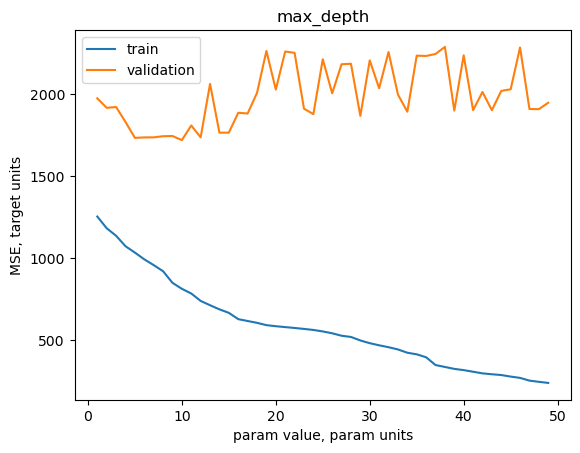

In [142]:
plot_fitting_curve(DecisionTreeRegressor, 'max_depth', np.arange(1, 50, 1), X_train, X_val, y_train, y_val)

100%|██████████| 25/25 [00:25<00:00,  1.03s/it]


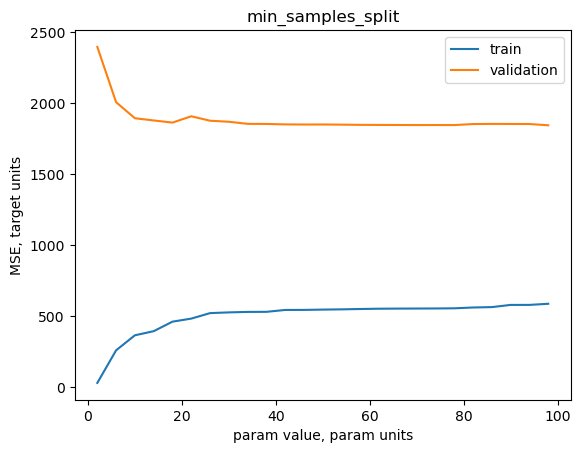

In [143]:
plot_fitting_curve(DecisionTreeRegressor, 'min_samples_split', np.arange(2, 100, 4),  X_train, X_val, y_train, y_val)

100%|██████████| 49/49 [00:15<00:00,  3.12it/s]


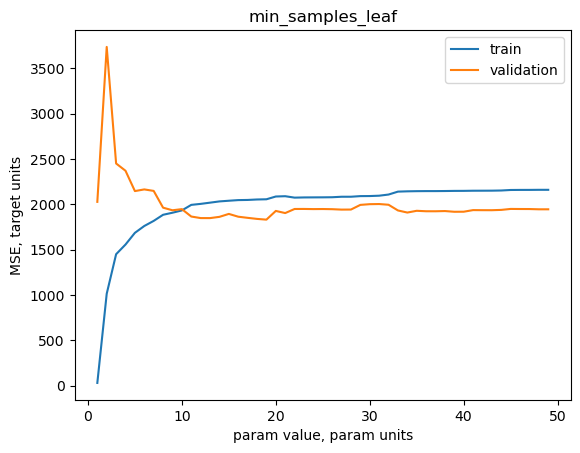

In [144]:
plot_fitting_curve(DecisionTreeRegressor, 'min_samples_leaf', np.arange(1, 50, 1),  X_train, X_val, y_train, y_val)

Ок, `min_samples_leaf` кажется достаточно стабильным гиперпараметром, который не сильно ухудшает MSE на валидации с увеличением его значения, установим его в 15.</br>
`min_samples_split` кажется достаточно стабильным гиперпараметром, который не сильно ухудшает MSE на валидации с увеличением его значения, установим его в 40. </br>
`max_depth` установим в 10. Кажется, что это +- минимум для нашего графика зависимости MSE от значения гиперпараметра.

In [172]:
parametrized_tree = DecisionTreeRegressor(min_samples_split=40, max_depth=10, min_samples_leaf=15)
parametrized_tree.fit(X_train, y_train)
y_pred_parametrized_tree = parametrized_tree.predict(X_test)
parametrized_tree_mse = metrics.mean_squared_error(y_test, y_pred_parametrized_tree)
parametrized_tree_r2 = r2_score(y_test, y_pred_parametrized_tree)
print('Decision tree MSE is {0}; Decision tree RMSE is {1}; Decision tree R2 is {2}'.format(parametrized_tree_mse, parametrized_tree_mse ** 0.5, parametrized_tree_r2))

Decision tree MSE is 1473.358512355879; Decision tree RMSE is 38.384352441533764; Decision tree R2 is 0.05679863091312942


Добились улучшения качества модели на тесте. MSE снизился с 2130 до 1473. R2 вырос с -0.36 до 0.056. То есть грубо говоря мы обогнали на тесте `DummyRegressor`, который предсказывает среднее.

# Простое ансамблирование (1 балл)

В этой секции мы реализуем простой ансамбль деревьев.

In [150]:
def get_random_states(merge_with, res_size):
    to_generate = res_size - len(merge_with)
    if to_generate <= 0:
        return merge_with
    return np.concatenate([merge_with, np.random.randint(100, 1000, to_generate)]).astype('int')
    
class EnsembleTreeRegressor:
    def __init__(self, num_trees=5, samples_frac=0.8, random_states=[], **model_kwargs):
        self._samples_frac = 0.8
        self._trees = [DecisionTreeRegressor(**model_kwargs) for _ in range(num_trees)]
        self._random_states=get_random_states(random_states, num_trees)

    def fit(self, x: pd.DataFrame, y: pd.Series):
        for i, tree in enumerate(self._trees):
            tree_x = x.sample(frac=self._samples_frac, random_state=self._random_states[i])
            tree_y = y[tree_x.index]
            tree.fit(tree_x, tree_y)

    def predict(self, x: pd.DataFrame):
        predictions = []
        for tree in self._trees:
            predictions.append(tree.predict(x))
        return np.mean(predictions, axis=0)
            
        

Проверьте, работает ли этот ансамбль лучше обычного дерева с параметрами по умолчанию?

Дополнительно переберите максимальную глубину дерева. Проверьте, насколько отличается момент начала переобучения у одиночного дерева и у ансамбля. Зависит ли этот момент от числа деревьев (`num_trees`)? От числа примеров для каждого дерева (`samples_frac`)? Постройте график fitting curve.

**Важно**: я подумал, что лучше будет убрать статический `random_state` из `x.sample`. Кажется, что нет смысла в том, чтобы усреднять одинаковые деревья. И тем более потом подбирать `num_trees`

In [201]:
# тут продублируем одинаковый random_state из 5 элементов 2 раза, дабы среднее предсказание на параметризованном ансамбле(используется 10 деревьев) и непараметризованном ансамбле(используется 5 деревьев) было одинаковым.
ensamble_random_state = np.tile(get_random_states([], 5), 2)
ensemble_tree = EnsembleTreeRegressor(random_states=ensamble_random_state)
ensemble_tree.fit(X_train, y_train)
ens_predictions = ensemble_tree.predict(X_test)
mse_ens = metrics.mean_squared_error(y_test, ens_predictions)
r2_ens = metrics.r2_score(y_test, ens_predictions)
print('Ensemble of trees MSE is {0}; Ensemble of trees RMSE is {1}; Enseble of trees R2 is {2}'.format(mse_ens, mse_ens ** 0.5, r2_ens))

Ensemble of trees MSE is 1579.5360464057508; Ensemble of trees RMSE is 39.743377390525715; Enseble of trees R2 is -0.011173145570500198


Непараметризованный ансамбль показывает результаты MSE и R2 ниже, чем дерево с параметрами(парам. дерево MSE = 1473, непарам. ансамбль MSE = 1580; парам. дерево R2 = 0.057, непарам. ансамбль R2 = -0.011)

100%|██████████| 49/49 [01:34<00:00,  1.92s/it]


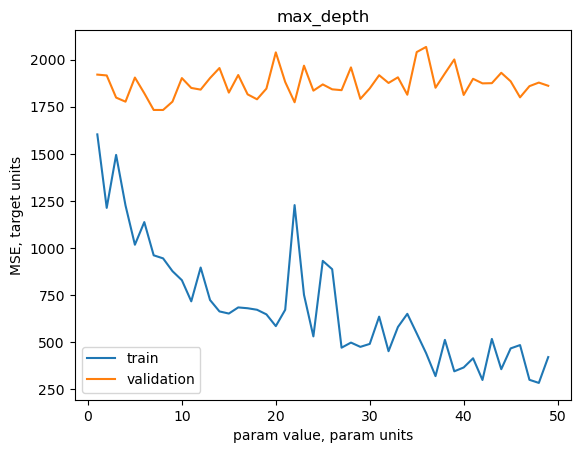

In [155]:
plot_fitting_curve(EnsembleTreeRegressor, 'max_depth', np.arange(1, 50, 1),  X_train, X_val, y_train, y_val)

100%|██████████| 49/49 [03:05<00:00,  3.79s/it]


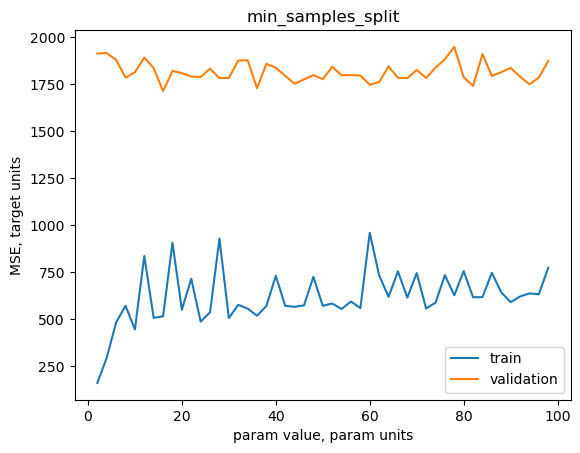

In [156]:
plot_fitting_curve(EnsembleTreeRegressor, 'min_samples_split', np.arange(2, 100, 2),  X_train, X_val, y_train, y_val)

100%|██████████| 49/49 [01:12<00:00,  1.49s/it]


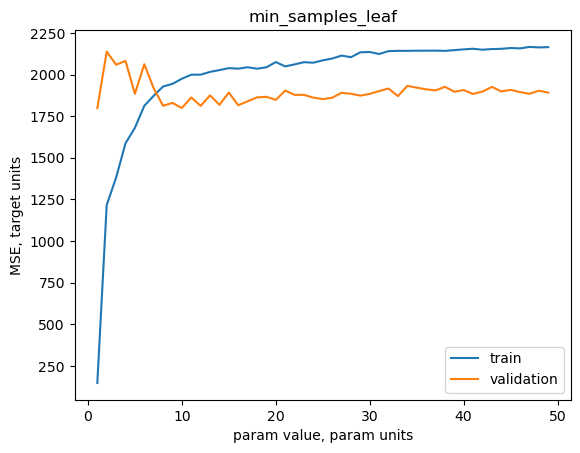

In [157]:
plot_fitting_curve(EnsembleTreeRegressor, 'min_samples_leaf', np.arange(1, 50, 1),  X_train, X_val, y_train, y_val)

Ниже привожу таблицу со всеми гиперпараметрами. Результаты в целом похожи. Как будто бы у ансамблей просто больше дисперсия для MSE, чем у обычного дерева. Попробуем подобрать `num_trees` и `samples_frac` и минимизировать ошибку на validation dataset

| Параметр          | Одиночное дерево                       | Ансамбль                                 |
|-------------------|----------------------------------------|------------------------------------------|
| max_depth         | 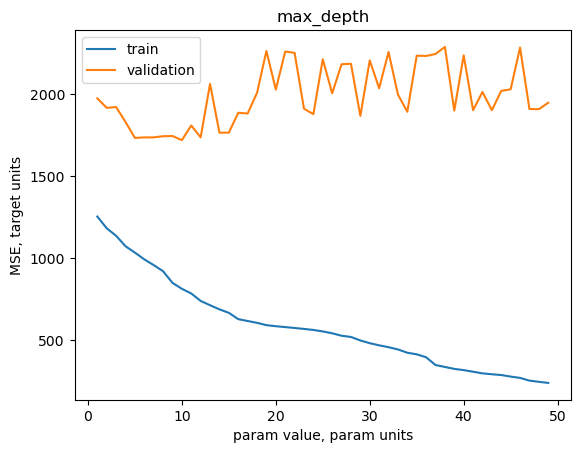 | 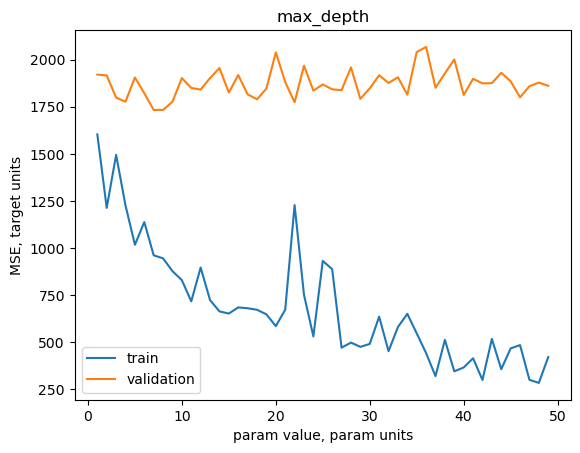   |
| min_samples_split | 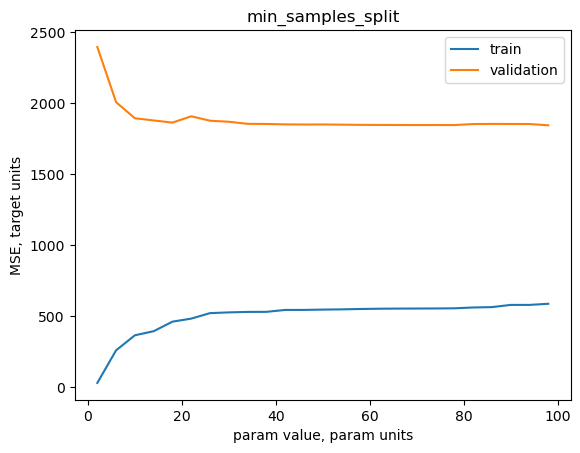 | 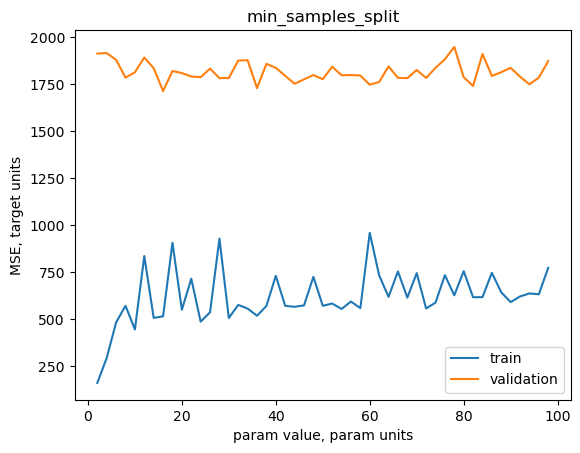 |
| min_samples_leaf  | 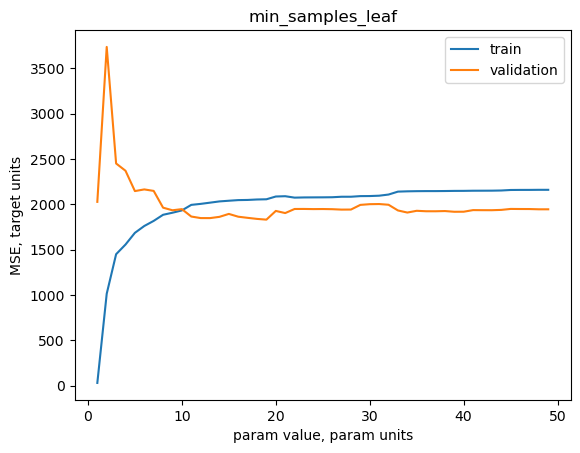 | 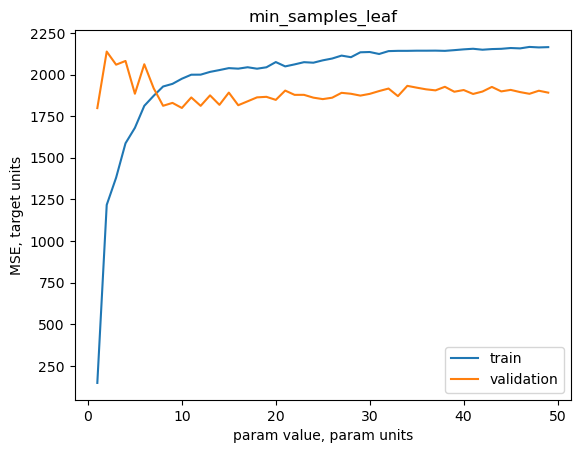   |

Попробуем подобрать гиперпараметры самого ансамбля с учетом лучших гиперпараметров деревьев.

100%|██████████| 18/18 [00:43<00:00,  2.41s/it]


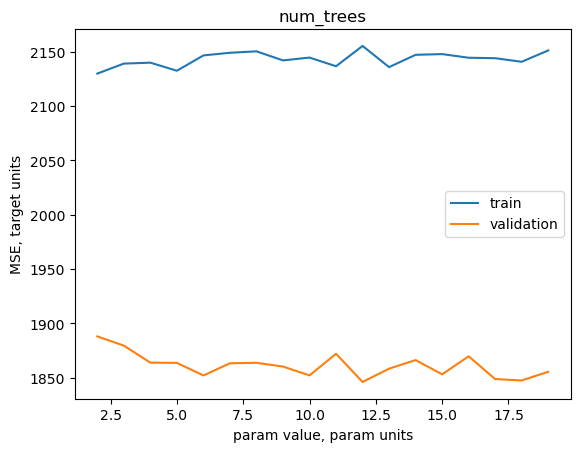

In [158]:
plot_fitting_curve(EnsembleTreeRegressor, 'num_trees', np.arange(2, 20, 1),  X_train, X_val, y_train, y_val, min_samples_split=55, max_depth=8, min_samples_leaf=20)

100%|██████████| 20/20 [00:23<00:00,  1.16s/it]


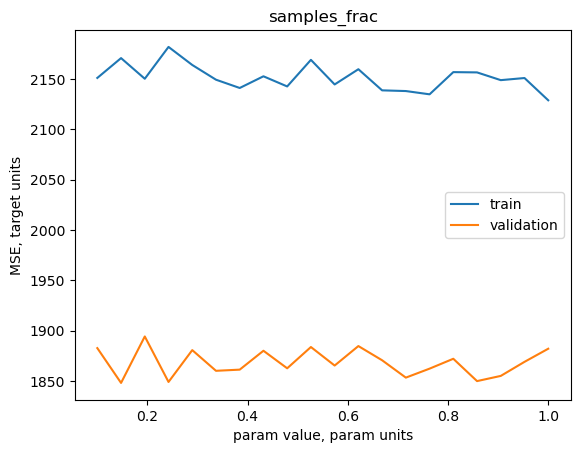

In [159]:
plot_fitting_curve(EnsembleTreeRegressor, 'samples_frac', np.linspace(0.1, 1, 20),  X_train, X_val, y_train, y_val, min_samples_split=55, max_depth=8, min_samples_leaf=20)

И в заключение попробуем обучить и посмотреть MSE ансамбля с лучшими параметрами, который состоит из деревьев с лучшими параметрами, уже на test датасете 

In [202]:
ensemble_tree_final = EnsembleTreeRegressor(num_trees=10, samples_frac=0.4, min_samples_split=55, max_depth=8, min_samples_leaf=20, random_states=ensamble_random_state)
ensemble_tree_final.fit(X_train, y_train)
ens_predictions_final = ensemble_tree_final.predict(X_test)
mse_ens_final = metrics.mean_squared_error(y_test, ens_predictions_final)
r2_ens_final = metrics.r2_score(y_test, ens_predictions_final)
print('Ensemble of trees MSE is {0}; Ensemble of trees RMSE is {1}; Enseble of trees R2 is {2}'.format(mse_ens_final, mse_ens_final ** 0.5, r2_ens_final))

Ensemble of trees MSE is 1463.8664205230787; Ensemble of trees RMSE is 38.260507321820484; Enseble of trees R2 is 0.06287519268483288


В целом небольшой прирост есть по сравнению с непараметризованным ансамблем (MSE снизился с 1580 до 1464, R2 увеличился с -0.011 до 0.063), но не знаю, насколько корректно такое сравнение, ведь мы использовали немного другой `random_state` в нашем параметризованном примере. Но мы взяли те же деревья, что и в непараметризованном варианте, только 2 раза. Должно быть тоже самое, только `num_trees` не будет использоваться, он будет статичен и равен `10`. Но это не столь важно, так как он не влияет особо на результат, как видно по графикам(там `random_state` действительно random). </br>
В результате мы имеем: для наших данных линейная регрессия сработала хуже всего. Хотя казалось бы: надо предсказать непрерывную переменную, линейная регрессия должна справиться получше. Видимо, данные были неразделимы, а ядра я не подбирал и особо feature engineereng-ом не занимался(ведь тема домашки - деревья). <br/>
`Samples_frac`, как и `num_trees` не играет большой роли в переобучении. Кажется, мы можем использовать любое значение этих параметров (`samples_frac` в диапазоне [0.1, 1], а `num_trees` в диапазоне [2, 20]). </br>
В общем, если брать R2 за ориентир, то топ выглядит так (R2 убывает сверху вниз):
1. Ансамбль с подобранными гиперпараметрами, содержащий деревья с подобранными гиперпараметрами (r2=0.06287519268483288)
2. Дерево с подобранными гиперпараметрами (r2=0.05679863091312942)
3. Dummy - предсказание mean (r2=-0.0006211873101502619)
4. Дефолтный ансамбль с дефолтными деревьями (r2=-0.011173145570500198)
5. Дефолтное дерево (r2=-0.255314441761757)
6. Линейная регрессия (r2=-9.75670906853224e+19)